Recommendation System
===========

Doc2vec + Wide & Deep 을 이용한 추천시스템
----------------------------------

<div style="text-align:right"><h3>
AgileSoda | 2017.09.08.
</h3></div>

---

### 순서

1. 데이터 불러오기
2. Wide & Deep
3. 결과
4. Cold start 문제
5. 결론


---

# 1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import Agile_data

In [2]:
Wide_data, Deep_data,train_label = Agile_data.load_Wide_Deep_train_data()
Wide_data_test, Deep_data_test, test_label = Agile_data.load_Wide_Deep_test_data()

### Wide input data

In [3]:
Wide_data.head()

,0,1,2,3,4,5,6,7,8,9,...,X15+X16_1.00.0,X15+X16_1.01.0,X15+X17_0.00.0,X15+X17_0.01.0,X15+X17_1.00.0,X15+X17_1.01.0,X16+X17_0.00.0,X16+X17_0.01.0,X16+X17_1.00.0,X16+X17_1.01.0
0,-0.000757,0.001210,0.000719,0.001681,0.001996,0.001242,-0.000085,-0.000496,0.002182,-0.001890,...,0,0,0,1,0,0,0,1,0,0
1,-0.229485,-0.120076,0.090476,-0.011354,-0.004279,0.177423,0.122731,0.019867,0.102183,-0.143541,...,0,1,0,0,0,1,0,0,0,1
2,-0.063811,0.006715,0.025582,0.026700,0.039148,0.031651,0.043512,-0.004721,0.021008,-0.036353,...,0,0,1,0,0,0,1,0,0,0
3,-0.000987,-0.000077,-0.000715,0.000863,-0.000943,-0.001618,-0.000788,0.000629,-0.001158,0.000429,...,1,0,0,0,1,0,1,0,0,0
4,-0.000302,0.000996,0.003372,0.002128,-0.000012,-0.000174,0.002966,0.000715,0.001500,-0.002877,...,0,0,1,0,0,0,1,0,0,0


### Deep input data

In [4]:
Deep_data.head()

,0,1,2,3,4,5,6,7,8,9,...,B01,B02,C01,C02,C03,D01,D02,성별,연령대,A거주지역
0,-0.000757,0.001210,0.000719,0.001681,0.001996,0.001242,-0.000085,-0.000496,0.002182,-0.001890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,6
1,-0.229485,-0.120076,0.090476,-0.011354,-0.004279,0.177423,0.122731,0.019867,0.102183,-0.143541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9,1
2,-0.063811,0.006715,0.025582,0.026700,0.039148,0.031651,0.043512,-0.004721,0.021008,-0.036353,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,4,5
3,-0.000987,-0.000077,-0.000715,0.000863,-0.000943,-0.001618,-0.000788,0.000629,-0.001158,0.000429,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,4,5
4,-0.000302,0.000996,0.003372,0.002128,-0.000012,-0.000174,0.002966,0.000715,0.001500,-0.002877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,1


In [5]:
Wide_data_test.shape

(13915, 844)

In [6]:
Deep_data_test.shape

(13915, 333)

---

# 2. Wide & Deep learning

Google 의 Wide&Deep Model[[3]](https://arxiv.org/abs/1606.07792) 은 추천시스템을 위해 태어났다고 해도 생각해도 좋습니다.  간단한 예를 들어보겠습니다.  

* 날개가 달린 동물은 날 수 있다.  

Deep Learning을 이용해서 위 `"Feature"`를 학습할 수 있습니다. 이것을 일반화(generalization) 라고 말합니다.. 하지만, 이는 모든 상황에 적용되지 않기 때문에 문제가 있습니다.

* 팽귄은 날개가 있다. 하지만 날지 못한다.

모형은 이렇게 특별한 경우를 기억해야 합니다. 이것은 Wide Linear 모형으로 문제를 해결할 수 있고, 기억(memorization) 이라고 말합니다.

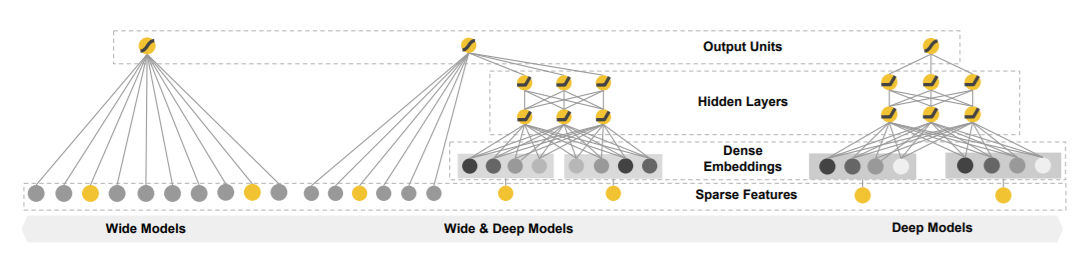

In [7]:
from IPython.display import Image
Image('images/wide_n_deep.png')

In [8]:
import tensorflow as tf
from tensorflow.contrib import layers
from datetime import datetime

In [9]:
# parameters
# keep_prob = 0.5
learning_rate = 1e-4
training_epochs = 10
batch_size = 256

wide_size = len(Wide_data.columns)
deep_size = len(Deep_data.columns) 
deep_embed_size = 2 # 임베딩할 컬럼 개수

output_size = len(train_label.columns)

He = tf.contrib.layers.variance_scaling_initializer()

# input place holders
tf.reset_default_graph()
Wide = tf.placeholder(tf.float32, [None, wide_size])
Deep_un_embed = tf.placeholder(tf.float32, [None, deep_size - deep_embed_size])
Deep_embed = tf.placeholder(tf.int32, [None, deep_embed_size])

Y = tf.placeholder(tf.float32, [None, output_size])
train_mode = tf.placeholder(tf.bool, name='train_mode')

추천시스템은 일반적인 Accuracy를 이용하지 않습니다. 878개나 되는 Label을 맞출 리 없죠.   
보통은 Top 3 내지 Top 20을 추천을 하게 됩니다.   
그중 실제로 고객이 구매한 내역과 비교하여 Hit rate: (맞춘 개수 / 추천한 개수) 를 보게 됩니다.   
Hit rate 는 통계학에서 Precision (정밀도) 라는 용어로 사용되고 있습니다.

#### Precision = tp / (tp + fp)
""    | Recommended | Not Recommended | Total
:-----|:-----------:|:--------------:|:--------
bought| tp | fn | ""
not bought | fp | tn | ""
Total | Top10 | 868 | 878

In [10]:
def get_acc(score_matrix, top_n, test_matix):
    avg_acc = 0
    for i in range(len(score_matrix)):
        top = score_matrix.iloc[i].nlargest(top_n).index
        tmp = 0
        for j in range(len(top)):
            if top[j] in test_matix["item"][i].split():
                tmp += 1

        acc = tmp / len(top)
        avg_acc += acc / len(score_matrix)

    return avg_acc

# 3. Wide & Deep 

In [11]:
no_class_max = 42
embedding_size = 5
Deep_col = Deep_data.columns

In [12]:
# `embedding_lookup` 함수를 이용해서 categorical 변수를 Embedding 합니다.
deep_embed_var = tf.Variable(tf.random_uniform([no_class_max, embedding_size], -1.0, 1.0))
deep_embed = tf.nn.embedding_lookup(deep_embed_var, Deep_embed)
deep_embed_re = tf.reshape(deep_embed, [-1, embedding_size * deep_embed_size])

Deep = tf.concat([Deep_un_embed, deep_embed_re], axis=1)

In [13]:
Deep

<tf.Tensor 'concat:0' shape=(?, 341) dtype=float32>

> 원래 Deep learning에 들어갈 input의 column 수는 333 개 였는데, 그 중 2개의 categorical 변수를 각각 5차원으로 Embedding하면 333 - 2 + 10 = 341 이 됩니다.

### Wide

In [14]:
A = tf.get_variable("A", shape=[wide_size, output_size])
b = tf.Variable(tf.random_normal([output_size]))

wide = tf.add(tf.matmul(Wide, A), b)

### Deep

In [15]:
W1 = tf.get_variable("W1", shape=[341, 512], initializer=He)
b1 = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(Deep, W1) + b1)

W2 = tf.get_variable("W2", shape=[512, 256], initializer=He)
b2 = tf.Variable(tf.random_normal([256]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W3 = tf.get_variable("W3", shape=[256, 128], initializer=He)
b3 = tf.Variable(tf.random_normal([128]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

W4 = tf.get_variable("W4", shape=[128, output_size], initializer=He)
b4 = tf.Variable(tf.random_normal([output_size]))

deep = tf.add(tf.matmul(L3, W4), b4)

In [16]:
hypothesis = wide + deep

In [17]:
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [18]:
Wide_n_Deep_ACC_plot = []

def Wide_n_Deep_Model(training_epochs = 10):
    
    feed_dict_test = {Wide: Wide_data_test,
                      Deep_un_embed: Deep_data_test[Deep_col[:-2]],
                      Deep_embed: Deep_data_test[Deep_col[-2:]]}
    
    try:
        print("가장 Hit-rate가 높았던 체크포인트를 로드합니다.")
        last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
        saver.restore(sess, save_path=last_chk_path)
        print("Restored checkpoint from:", last_chk_path)
        
        score = sess.run(tf.sigmoid(hypothesis), feed_dict=feed_dict_test)
        WD_score = pd.DataFrame(score, columns=train_label.columns)
        
        print("Hit rate of Top 3: {:>.5f}".format(get_acc(WD_score, 3, test_label)))
        print("Hit rate of Top 10: {:>.5f}".format(get_acc(WD_score, 10, test_label)))
        print("Hit rate of Top 20: {:>.5f}".format(get_acc(WD_score, 20, test_label)))
        
        
        
    except:
        print("체크포인트가 없습니다. 변수를 초기화 합니다.")
        print("----------------------------------------------")
        sess.run(tf.global_variables_initializer())

        max_acc = 0
        for epoch in range(training_epochs):
            avg_cost = 0
            total_batch = int(len(Deep_data) / batch_size)

            
            for i in range(0, len(Deep_data), batch_size):
                batch_wide = Wide_data[i:i+batch_size]
                batch_deep = Deep_data[i:i+batch_size][Deep_col[:-2]]
                batch_deep_embed = Deep_data[i:i+batch_size][Deep_col[-2:]]

                batch_label = train_label[i:i+batch_size]

                feed_dict_train = {Wide: batch_wide,
                                   Deep_un_embed: batch_deep,
                                   Deep_embed: batch_deep_embed,
                                   Y: batch_label}

                opt, c = sess.run([optimizer, cost], feed_dict=feed_dict_train)

                avg_cost += c/total_batch

                
            # 2번마다 Hit-rate를 계산합니다.
            # if (epoch % 2 == 0) or (epoch == training_epochs - 1):

            score = sess.run(tf.sigmoid(hypothesis), feed_dict=feed_dict_test)
            
            score_pd = pd.DataFrame(score, columns=train_label.columns)
            acc = get_acc(score_pd, 10, test_label)
            Wide_n_Deep_ACC_plot.append(acc)


            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            main = "[Epoch: {:>4}][Cost: {:>.5f}][Hit rate of Top 10: {:>.5f}]"
            print(main.format(epoch, avg_cost, acc))


            # Hit-rate가 가장 높은 score를 저장합니다.
            if acc > max_acc:
                WD_score = score_pd
                saver.save(sess, save_path=save_path, global_step=epoch)
                print("Saved checkpoint.")

            max_acc = max(max_acc, acc)
                

        print('Learning Finished!')
        print("----------------------------------------------")
        print("가장 Hit-rate가 높았던 체크포인트를 로드합니다.")
        last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
        saver.restore(sess, save_path=last_chk_path)
        
        print("Hit rate of Top 3: {:>.5f}".format(get_acc(WD_score, 3, test_label)))
        print("Hit rate of Top 10: {:>.5f}".format(get_acc(WD_score, 10, test_label)))
        print("Hit rate of Top 20: {:>.5f}".format(get_acc(WD_score, 20, test_label)))
        

    return WD_score

## Session

In [19]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

## Saver

In [20]:
import os
save_dir = 'WnD_model/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'WnD_tensorflow')
saver = tf.train.Saver()

In [21]:
WD_score = Wide_n_Deep_Model(51)

가장 Hit-rate가 높았던 체크포인트를 로드합니다.
INFO:tensorflow:Restoring parameters from None
체크포인트가 없습니다. 변수를 초기화 합니다.
----------------------------------------------
[Epoch:    0][Cost: 0.20604][Hit rate of Top 10: 0.09243]
Saved checkpoint.
[Epoch:    1][Cost: 0.02035][Hit rate of Top 10: 0.12688]
Saved checkpoint.
[Epoch:    2][Cost: 0.01826][Hit rate of Top 10: 0.14277]
Saved checkpoint.
[Epoch:    3][Cost: 0.01721][Hit rate of Top 10: 0.15225]
Saved checkpoint.
[Epoch:    4][Cost: 0.01649][Hit rate of Top 10: 0.15833]
Saved checkpoint.
[Epoch:    5][Cost: 0.01598][Hit rate of Top 10: 0.16090]
Saved checkpoint.
[Epoch:    6][Cost: 0.01559][Hit rate of Top 10: 0.16246]
Saved checkpoint.
[Epoch:    7][Cost: 0.01528][Hit rate of Top 10: 0.16310]
Saved checkpoint.
[Epoch:    8][Cost: 0.01502][Hit rate of Top 10: 0.16421]
Saved checkpoint.
[Epoch:    9][Cost: 0.01481][Hit rate of Top 10: 0.16436]
Saved checkpoint.
[Epoch:   10][Cost: 0.01463][Hit rate of Top 10: 0.16466]
Saved checkpoint.
[Epoch:   11]

In [22]:
import matplotlib.pyplot as plt
import numpy as np

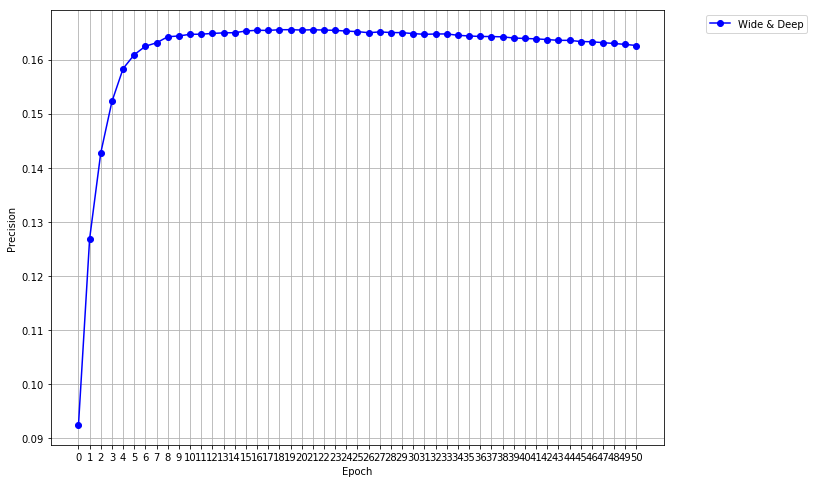

In [23]:
builds = np.array(list(range(0, 51, 1)))

fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.plot(builds, Wide_n_Deep_ACC_plot, label='Wide & Deep', color='b', marker='o')

plt.xticks(builds)
plt.xlabel('Epoch')
plt.ylabel('Precision')

handles, labels = ax1.get_legend_handles_labels()
lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
ax1.grid('on')
plt.savefig('Wide_Deep_Model.png')
plt.show()

Hit-rate가 가장 높았던 부분은 Epoch 가 19이었던 부분입니다.  
10개를 추천해준다면 그 중 16.552% 가량을 실제로 구매하는 것으로 나타났습니다.    
(여러번 돌려본 결과 16.5 ~ 16.6 사이를 왔다갔다 합니다.)

---

14674번 고객과 6887번 고객을 예를 들면 위 모델로 추천을 해준 아이템 10개는 다음과 같으며  
실제 고객이 구매한 아이템은 그 밑에 나타냈습니다.

In [24]:
test_data = pd.read_csv("./Lpoint_data/test_data.csv", encoding="cp949")

test_docs = [(str(row['item']).split(), row['고객번호']) for idx, row in test_data.iterrows()]

In [25]:
print(test_docs[0])
print(list(test_label.iloc[0]))
print(list(WD_score.iloc[0].nlargest(10).index))

(['C060206/온장조리원부재료'], 14674)
['C060206/온장조리원부재료', 4358, 14674]
['C060406/베이커리일반빵', 'C060504/기타냉장조리', 'C060402/일반빵', 'C060503/기타온장조리', 'C060403/호빵찐빵', 'C060502/피자', 'C060205/즉석어묵', 'C060506/일반떡', 'C060401/식빵', 'C060308/햄버거']


### ID: 14674

* 구매했던 상품들

상품 명             | 상품 명          | 상품 명
:-------------------|:-----------------|:------------------
'C060206/온장조리원부재료' |  | 

* 추천 상품 

상품 명             | 상품 명          | 상품 명
:-------------------|:-----------------|:------------------
'C060406/베이커리일반빵' | 'C060504/기타냉장조리' | 'C060402/일반빵'
'C060503/기타온장조리' | 'C060403/호빵찐빵' | 'C060502/피자'
'C060205/즉석어묵' | 'C060506/일반떡' | 'C060401/식빵'
'C060308/햄버거' |  | 

* 실제 마지막 구매 상품  

상품 명             | 상품 명          | 상품 명
:-------------------|:-----------------|:------------------
'C060206/온장조리원부재료' |  | 


* Hit rate:  0/10  
(추천해준 상품에서 실제 구매한 상품의 개수 / 추천해준 상품의 개수)

> 14674 번 고객은 __'온장조리원부재료'__를 딱 1번 구매한 고객입니다.  
이렇게 고객의 구매 데이터가 거의 없어도  __`기타냉장조리`, `기타온장조리`__ 등 상위카테고리 06 범주에서 비슷한 상품들을 추천해주는 모습입니다.

In [26]:
print(test_docs[1])
print(list(test_label.iloc[1]))
print(list(WD_score.iloc[1].nlargest(10).index))

(['C120202/수입맥주', 'C170206/종량제봉투', 'C120202/수입맥주', 'C170206/종량제봉투'], 66)
['C140501/설탕 C150301/크래커 C150405/일반스낵 C170206/종량제봉투', 24463, 66]
['C170701/생활잡화균일가', 'C170206/종량제봉투', 'C150101/국물봉지라면', 'C150405/일반스낵', 'C150401/감자스낵', 'C150302/쿠키', 'C140501/설탕', 'C150301/크래커', 'C140302/식초', 'C150306/파이']


### ID: 66

* 구매했던 상품들

상품 명             | 상품 명          | 상품 명
:-------------------|:-----------------|:------------------
'C120202/수입맥주' | 'C170206/종량제봉투' | 'C120202/수입맥주'
'C170206/종량제봉투' |  | 


* 추천 상품 

상품 명             | 상품 명          | 상품 명
:-------------------|:-----------------|:------------------
'C170701/생활잡화균일가' | 'C170206/종량제봉투' | 'C150101/국물봉지라면'
'C150405/일반스낵' | 'C150401/감자스낵' | 'C150302/쿠키'
'C140501/설탕' | 'C150301/크래커' | 'C140302/식초'
'C150306/파이' |  | 
 

* 실제 마지막 구매 상품  

상품 명             | 상품 명          | 상품 명
:-------------------|:-----------------|:------------------
C140501/설탕 | C150301/크래커 | C150405/일반스낵
C170206/종량제봉투 |  | 

* Hit rate:  4/10  
(추천해준 상품에서 실제 구매한 상품의 개수 / 추천해준 상품의 개수)

> __수입맥주, 종량제봉투__ 를 서로 다른날에 2번 구매한 고객입니다. 스낵류를 여러가지 추천해준 모습이 인상적입니다.   
또한 연관성이 <U>전혀</U> 없을 것 같은 __식초, 설탕__ 을 추천해 주었는데 __설탕__을 실제로 구매한 결과가 아주 놀랍습니다!


---

# 5. Cold start 문제

Cold start 문제란 구매이력이 없는 User에게 추천을 해주는 문제를 말합니다.  
기존의 CF 에서는 Rating에 의존한 추천을 해주다 보니, 이런 구매이력이 없는 고객에게는 추천을 하지 못하는 문제가 있었습니다. 그러다 보니 보통 가장 인기가 많은 Item들을 추천을 해주는 경향이 있습니다.    

Neural Network를 이용한 모형에서도 이러한 문제가 존재합니다.  하지만 이 모형에는 고객의 특징을 설명하는 변수가 존재하기 때문에 __User Feaures__를 이용해서 추천을 해 주는 것이 가능합니다.

위 모형에서 구매 이력이 단 1개인 고객은 분석에서 제외했었습니다. Train set만 있고 Test set 이 없었기 때문입니다.   

이번 단계에서 그 고객의 User Feature만 사용해 추천을 하고, 그 1번 뿐인 구매이력으로 정확도를 측정하도록 하겠습니다. 

In [27]:
pred_label, pred_label_eval, pred_categorical, pred_continuous \
= Agile_data.load_pred_data()

In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [29]:
pred_categorical["성별"] = le.fit_transform(pred_categorical["성별"])
pred_categorical["연령대"] = le.fit_transform(pred_categorical["연령대"])
pred_categorical["A거주지역"] = le.fit_transform(pred_categorical["A거주지역"])

pred_user_feartures = pd.concat([pred_continuous, pred_categorical], axis=1)

In [30]:
pred_user_feartures.head()

,다둥이,더영,롭스,하이마트,A01,A02,B01,B02,C01,C02,C03,D01,D02,성별,연령대,A거주지역
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,6
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9,6
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,6
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,1


In [31]:
Wide_data_pred = pd.DataFrame(np.zeros((3195, 844)))
Wide_data_pred.columns = Wide_data.columns

In [32]:
Deep_data_pred_ = pd.DataFrame (np.zeros((3195, 317)))
Deep_data_pred = pd.concat([Deep_data_pred_, pred_user_feartures], axis=1)
Deep_data_pred.columns = Deep_data.columns

In [33]:
print(Wide_data_pred.shape)
print(Deep_data_pred.shape)

(3195, 844)
(3195, 333)


In [34]:
feed_dict_pred = {Wide: Wide_data_pred,
                  Deep_un_embed: Deep_data_pred[Deep_col[:-2]],
                  Deep_embed: Deep_data_pred[Deep_col[-2:]]}

In [35]:
score_pred = sess.run(tf.sigmoid(hypothesis), feed_dict=feed_dict_pred)
score_pred = pd.DataFrame(score_pred, columns=train_label.columns)

In [36]:
print("Hit rate of Top 3: {:>.5f}".format(get_acc(score_pred, 3, pred_label)))
print("Hit rate of Top 10: {:>.5f}".format(get_acc(score_pred, 10, pred_label)))

Hit rate of Top 3: 0.06093
Hit rate of Top 10: 0.04203


~~정확도는 형편없습니다...~~  
그 결과를 보면 아래와 같습니다. 

---

In [37]:
reco = []
for i in [0, 5, 10, 50, 100, 500, 1000]:
    reco.append(list(score_pred.iloc[i].nlargest(10).index))

reco_pd = pd.DataFrame(reco)

random_user =  pred_user_feartures.loc[[0, 5, 10, 50,100, 500, 1000]]

In [38]:
how_reco = pd.concat([random_user.reset_index(drop=True), reco_pd], axis=1)
how_reco

,다둥이,더영,롭스,하이마트,A01,A02,B01,B02,C01,C02,...,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,C120101/일반소주,C170701/생활잡화균일가,C030302/고구마,C070101/일반우유,C070103/가공우유,C150401/감자스낵,C110203/콜라,C060504/기타냉장조리,C090102/튜브아이스크림,C030103/상추
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,C120101/일반소주,C170701/생활잡화균일가,C030302/고구마,C070101/일반우유,C150401/감자스낵,C070103/가공우유,C110203/콜라,C090102/튜브아이스크림,C150306/파이,C060504/기타냉장조리
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,C120101/일반소주,C170701/생활잡화균일가,C030302/고구마,C070101/일반우유,C070103/가공우유,C110203/콜라,C150401/감자스낵,C090102/튜브아이스크림,C150306/파이,C060504/기타냉장조리
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,C120101/일반소주,C170701/생활잡화균일가,C030302/고구마,C070103/가공우유,C070101/일반우유,C150401/감자스낵,C110203/콜라,C060504/기타냉장조리,C090102/튜브아이스크림,C150306/파이
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,C120101/일반소주,C170701/생활잡화균일가,C030302/고구마,C070101/일반우유,C070103/가공우유,C150401/감자스낵,C110203/콜라,C060504/기타냉장조리,C090102/튜브아이스크림,C030103/상추
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,C120101/일반소주,C170701/생활잡화균일가,C070101/일반우유,C030302/고구마,C070103/가공우유,C150401/감자스낵,C110203/콜라,C060504/기타냉장조리,C090102/튜브아이스크림,C150306/파이
6,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,C120101/일반소주,C170701/생활잡화균일가,C030302/고구마,C070101/일반우유,C110203/콜라,C150401/감자스낵,C070103/가공우유,C060504/기타냉장조리,C090102/튜브아이스크림,C030103/상추


성별, 연령대, 거주지역에 따라 그 순서가 약간 다르긴 하지만,  추천된 상품들을 보면
* 2번째로 잘팔린 __일반우유__
* 6번째 로 잘팔린 __일반계란__
* 12번째 __마시는요구르트__  
등도 포함되었으며 기타 다양한 상품들이 추천된 모습을 보입니다.

In [39]:
# 가장 많이 팔린 상품  20 개
train_label_Rating = train_label.apply(np.sum, axis = 0)
train_label_Rating = pd.DataFrame(train_label_Rating)
train_label_Rating.nlargest(20, 0)

,0
C170206/종량제봉투,12763.0
C070101/일반우유,8321.0
C170701/생활잡화균일가,8096.0
C030401/두부류,7609.0
C150405/일반스낵,7322.0
C030901/일반계란,6281.0
C010206/바나나,5364.0
C120201/국산맥주,4959.0
C110101/생수,4948.0
C150101/국물봉지라면,4885.0


설명 변수로 사용되는 User Feature들이 다양할 수록 그 결과갑이 좋을것으로 예상되며  
Doc2Vec과 Wide&Deep 모형들의 변수들이 random 하게 update 되므로 위 결과값도 그때 그때 다르게 나옵니다. 모형을 구축할 때 정확히 저장을 해야 할 것 같습니다.  

## 결론